In [26]:
using Phylo

assetpath = joinpath("..", "assets")
hummers = open(t -> parsenewick(t, NamedPolytomousTree), joinpath(assetpath, "hummingbirds.tree"))

NamedTree with 126 tips and 1 root. Leaf names are Adelomyia_melanogenys, Aglaiocercus_coelestis, Aglaiocercus_kingi, Chalcostigma_herrani, Oxypogon_guerinii, ... [120 omitted] ... and Florisuga_mellivora

251 nodes: [Adelomyia_melanogenys, Aglaiocercus_coelestis, Aglaiocercus_kingi, Node 4, Node 5 ... 245 missing ... Node 251]

250 branches: [Branch{ManyRoots, String}(56, "Node 59", "Node 53", 0.10359464), Branch{ManyRoots, String}(35, "Node 38", "Node 36", 0.02788159), Branch{ManyRoots, String}(60, "Node 63", "Node 59", 0.02343217), Branch{ManyRoots, String}(220, "Node 223", "Node 222", 0.04006476), Branch{ManyRoots, String}(67, "Node 72", "Heliodoxa_aurescens", 0.11882236) ... 244 missing ... Branch{ManyRoots, String}(65, "Node 71", "Node 69", 0.00427061)]

Node records: "Adelomyia_melanogenys" => Dict{String, Any}() ... "Node 251" => Dict{String, Any}()


In [27]:
simple = open(t -> parsenewick(t, NamedPolytomousTree), joinpath(assetpath, "simple.tree"))

NamedTree with 5 tips and 1 root. Leaf names are A, B, C, D and G

9 nodes: [A, B, Node 3, C, D, Node 6, Node 7, G and Node 9]

8 branches: [Branch{ManyRoots, String}(5, "Node 7", "Node 3", 0.3), Branch{ManyRoots, String}(4, "Node 6", "D", 0.3), Branch{ManyRoots, String}(6, "Node 7", "Node 6", 0.2), Branch{ManyRoots, String}(7, "Node 9", "G", 0.7), Branch{ManyRoots, String}(2, "Node 3", "A", 0.2), Branch{ManyRoots, String}(8, "Node 9", "Node 7", 0.3), Branch{ManyRoots, String}(3, "Node 6", "C", 0.5) and Branch{ManyRoots, String}(1, "Node 3", "B", 0.3)]

Node records: "A" => Dict{String, Any}() ... "Node 9" => Dict{String, Any}()


In [2]:
mutable struct BaryCentricContext 
    coefficient::Dict{Any, Real} #c
    offset::Dict{Any, Vector{Real}} #d
    weights::Dict{Phylo.AbstractBranch, Real} #s
    coords::Dict{Any, Vector{Real}}
    total::Int
    current::Int
end

In [3]:
function baryplot(tree)
    leaves = getleaves(tree)
    context = BaryCentricContext(Dict(), Dict(), Dict(), Dict(), length(leaves), 0)
    context = tpostorder(tree, getroot(tree), context)
    context = tpreorder(tree, getroot(tree), context)

    return context
end

function comparesize(tree, n, a, b)
    asize = getlength(tree, getbranch(tree, n, a)) + getheight(tree, a)
    bsize = getlength(tree, getbranch(tree, n, b)) + getheight(tree, b)

    return asize < bsize
end

function tpostorder(tree, node, context::BaryCentricContext)
    for child in sort(getchildren(tree, node);lt=(a,b) -> comparesize(tree, node, a, b))
        context = tpostorder(tree, child, context)
    end
    # fix leaves on outer circle
    if isleaf(tree, node) || (isroot(tree, node) && degree(tree, node) == 1)
        context.coefficient[node] = 0.0
        segment = (2*pi*context.current)/context.total
        context.offset[node] = [cos(segment), sin(segment)]
        context.current += 1
    else
        s = 0.0
        for branch in getconnections(tree, node)
            if isroot(tree, node) || src(tree, branch) == getparent(tree, node) # check parent case
                context.weights[branch] = 1.0/getlength(tree, branch)
            else
                context.weights[branch] = 1.0/getlength(tree, branch)*(degree(tree, node)-1)
            end
            s += context.weights[branch]
        end
        t = t1 = 0.0
        for outgoing in getoutbounds(tree, node)
            destination = dst(tree, outgoing)
            t = t + context.weights[outgoing]/s * context.coefficient[destination]
            t1 = t1 .+ context.weights[outgoing]/s .* context.offset[destination]
        end
        if !isroot(tree, node)
            e = getbranch(tree, getparent(tree, node), node)
            context.coefficient[node] = context.weights[e]/(s*(1-t))
        end
        context.offset[node] = t1./(1-t)
    end
    return context
end

function tpreorder(tree, node, context::BaryCentricContext)
    if isroot(tree, node)
       context.coords[node] = context.offset[node] 
    else
        parent = getparent(tree, node)
        context.coords[node] = context.coefficient[node] * context.coords[parent] + context.offset[node]
    end
    for child in getchildren(tree, node)
        context = tpreorder(tree, child, context)
    end
    return context
end

tpreorder (generic function with 1 method)

In [4]:
ctx = baryplot(hummers)

BaryCentricContext(Dict{Any, Real}("Chalcostigma_stanleyi" => 0.0, "Lafresnaya_lafresnayi" => 0.0, "Amazilia_tzacatl" => 0.0, "Node 41" => 0.4946848051594487, "Polytmus_guainumbi" => 0.0, "Lesbia_victoriae" => 0.0, "Oxypogon_guerinii" => 0.0, "Node 136" => 0.351461289833965, "Phlogophilus_hemileucurus" => 0.0, "Patagona_gigas" => 0.0…), Dict{Any, Vector{Real}}("Chalcostigma_stanleyi" => [0.58374367223479, 0.8119380057158565], "Lafresnaya_lafresnayi" => [-0.9888308262251285, 0.14904226617617472], "Amazilia_tzacatl" => [-0.5837436722347906, -0.811938005715856], "Node 41" => [0.22932860817499076, 0.41426935043811025], "Polytmus_guainumbi" => [0.969077286229078, 0.24675739769029362], "Lesbia_victoriae" => [0.7330518718298263, 0.6801727377709194], "Oxypogon_guerinii" => [0.5425462638657594, 0.8400259231507714], "Node 136" => [-0.4827128822575202, -0.42900741956684746], "Phlogophilus_hemileucurus" => [-0.024930691738072913, 0.9996891820008162], "Patagona_gigas" => [0.5425462638657597, -0.840

In [5]:
using CairoMakie

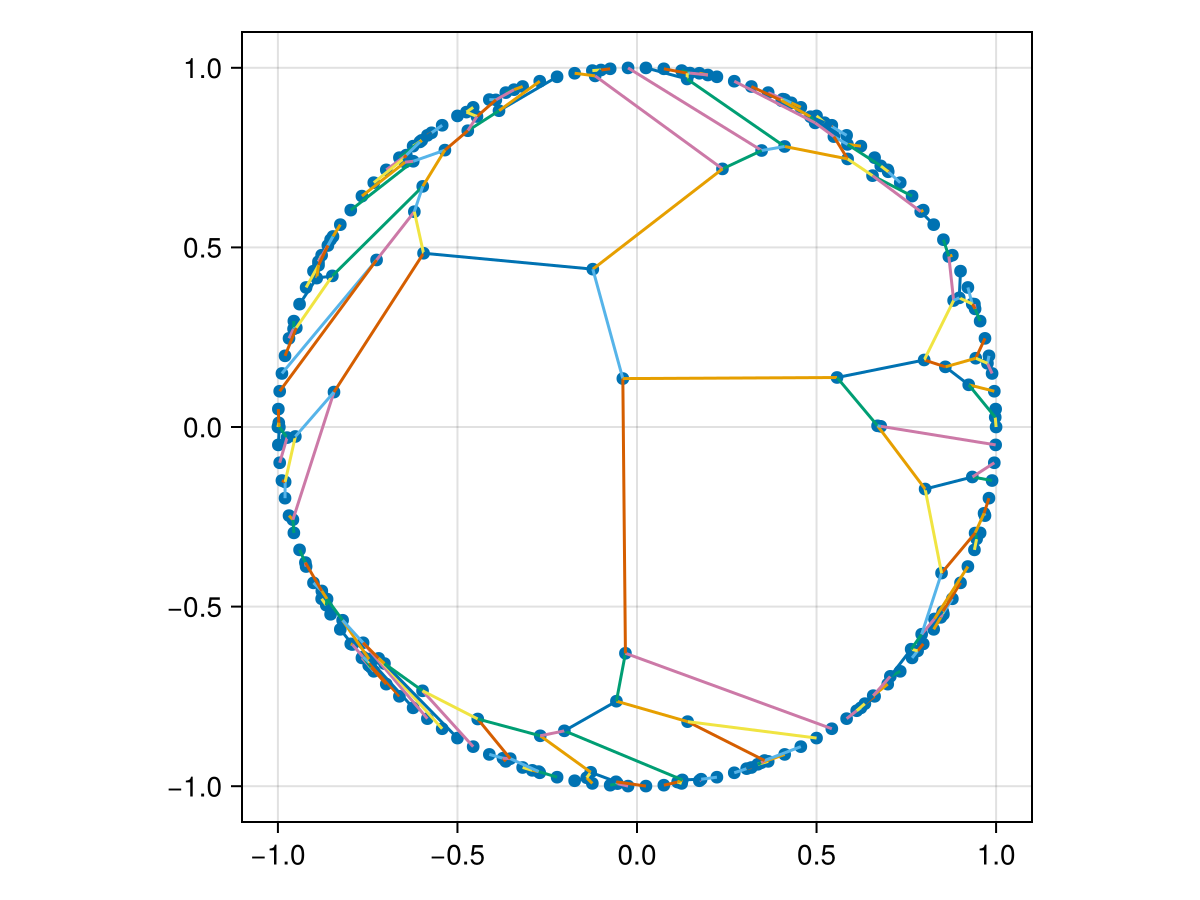

In [6]:
c = [value for (key, value) in ctx.coords]

c = reduce(hcat,c)'

f, ax, sc = scatter(c[:,1], c[:,2])
ax.aspect = 1

for node in getnodes(hummers)
    for child in getchildren(hummers, node)
        cx, cy = ctx.coords[child]
        px, py = ctx.coords[node]
        lines!(ax, [cx, px], [cy, py])
    end
end

current_figure()

In [7]:
using Phylo

mutable struct RadialContext
    coords::Dict{Any, Vector{Real}} #x
    angle::Dict{Any, Real} #τ
    wedge::Dict{Any, Real} #ω
    leaves::Dict{Any, Int}
end

function radialplot(tree)
    context = RadialContext(Dict(), Dict(), Dict(), Dict())
    root = getroot(tree)
    context.leaves = rpostorder(tree, root, Dict())
    context.coords[root] = [0.0, 0.0]
    context.wedge[root] = 2*pi
    context.angle[root] = 0.0
    context = rpreorder(tree, root, context)
    return context
end

function rpreorder(tree, node, ctx::RadialContext)
    if !isroot(tree, node)
        parent = getparent(tree, node)
        branch = getbranch(tree, parent, node)
        segment = ctx.angle[node] + ctx.wedge[node]/2.0
        ctx.coords[node] = ctx.coords[parent] + getlength(tree, branch) .* [cos(segment), sin(segment)]
    end
    mu = ctx.angle[node]
    for child in getchildren(tree, node)
        ctx.wedge[child] = ctx.leaves[child]/ctx.leaves[getroot(tree)] * 2.0 *pi
        ctx.angle[child] = mu
        mu += ctx.wedge[child]
        ctx = rpreorder(tree, child, ctx)
    end
    return ctx
end

function rpostorder(tree, node, leaves=Dict())
    if isleaf(tree, node)
        leaves[node] = 1
    else
        leaves[node] = 0
        for child in getchildren(tree, node)
            leaves = rpostorder(tree, child, leaves)
            leaves[node] += leaves[child]
        end
    end
    return leaves
end

rpostorder (generic function with 2 methods)

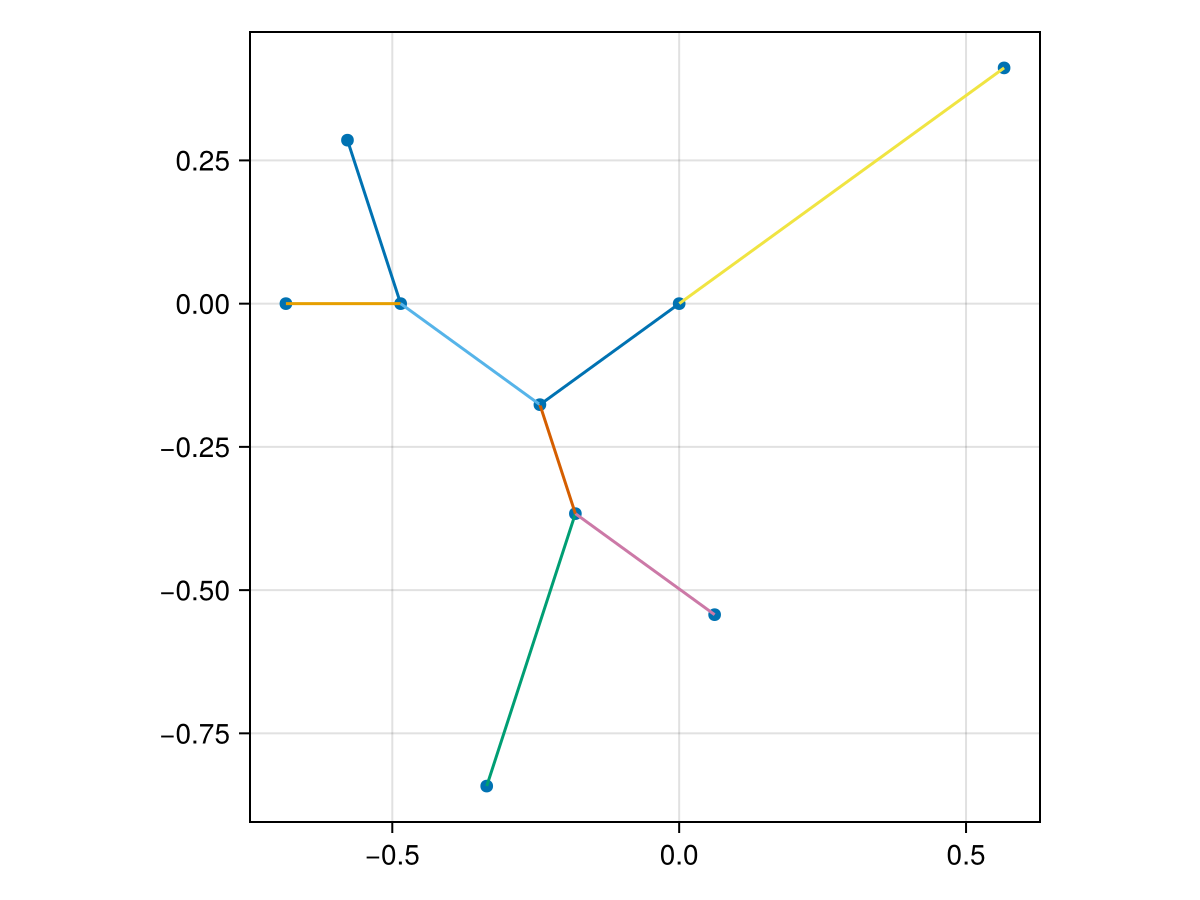

In [32]:
ctx2 = radialplot(simple)
c = [value for (key, value) in ctx2.coords]

c = reduce(hcat,c)'

f, ax, sc = scatter(c[:,1], c[:,2])
ax.aspect = 1

for node in getnodes(simple)
    for child in getchildren(simple, node)
        cx, cy = ctx2.coords[child]
        px, py = ctx2.coords[node]
        lines!(ax, [cx, px], [cy, py])
    end
end

current_figure()

In [19]:
using Phylo

mutable struct HVContext
    coords::Dict{Any, Vector{Real}}
    leaves::Dict{Any, Int}
end

function hvplot(tree)
    ctx = HVContext(Dict(), Dict())
    root = getroot(tree)
    ctx.leaves = rpostorder(tree, root)
    ctx, _ = hvpreorder(tree, root, ctx)
    return ctx
end

function hvpreorder(tree, node, ctx::HVContext, ix::Int=0, iy::Int=0)
    children = getchildren(tree, node)
    ctx.coords[node] = [ix, iy]
    if isleaf(tree, node)
        return ctx, 0
    elseif length(children) == 1
        child = first(children)
        _, width = hvpreorder(tree, child, ctx, ix+1, iy)
        return ctx, width + 1

    elseif length(children) == 2
        small, large = children
        smallsize, largesize = ctx.leaves[small], ctx.leaves[large]
        if largesize < smallsize
            # do swap so bigger node always sits in large
            tmp = large
            large = small
            small = tmp
        end
        _, widthsmall = hvpreorder(tree, small, ctx, ix, iy+1)
        _, widthlarge = hvpreorder(tree, large, ctx, ix+1+widthsmall, iy)
        return ctx, widthsmall + widthlarge + 1
    else
        error("Tree is not binary")
    end
end

hvpreorder (generic function with 3 methods)

In [30]:
ctx3 = hvplot(simple)

HVContext(Dict{Any, Vector{Real}}("B" => [1, 2], "A" => [2, 1], "C" => [3, 1], "D" => [4, 0], "Node 9" => [0, 0], "G" => [0, 1], "Node 3" => [1, 1], "Node 7" => [1, 0], "Node 6" => [3, 0]), Dict{Any, Int64}("B" => 1, "A" => 1, "C" => 1, "D" => 1, "Node 9" => 5, "G" => 1, "Node 3" => 2, "Node 7" => 4, "Node 6" => 2))

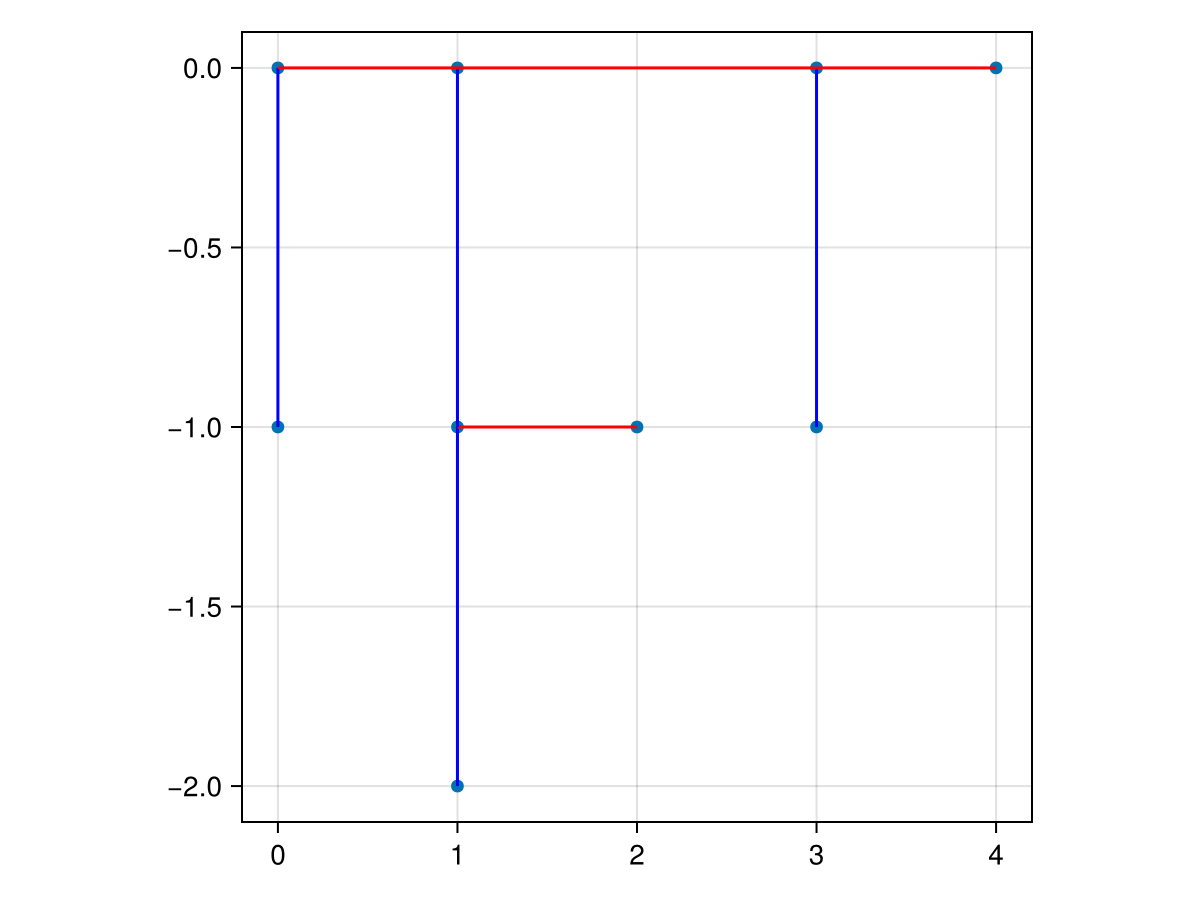

In [31]:
c = [value for (key, value) in ctx3.coords]

c = reduce(hcat,c)'

f, ax, sc = scatter(c[:,1], -c[:,2])
ax.aspect = 1

for node in getnodes(simple)
    for child in getchildren(simple, node)
        cx, cy = ctx3.coords[child]
        px, py = ctx3.coords[node]
        vx, vy = [cx, cy] - [px, py]
        lcolor = :red
        if vx == 0
            lcolor = :blue
        end
        lines!(ax, [cx, px], [-cy, -py]; color=lcolor)
    end
end

current_figure()